In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../lib/src/')
sys.path.append('../../TopographicVAE-master')
import torch
import numpy as np
from torch import nn
import os
from matplotlib import pyplot as plt
from itertools import islice
import lightning as L
import logging
from sklearn.decomposition import PCA

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0), cmap = 'gray')
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)

def extract_dataset(loader, only_last = False, c = 3, h = 28, w = 28):
    dataset = []

    for data, label in loader:
        data = data.squeeze(2,3) #(32, 18, 3, 28, 28)
        if only_last:
            data = data[:, -1]
        data = data.reshape(-1, c, h, w)
        dataset.append(data)
    
    dataset = torch.cat(dataset, 0)
    return dataset

%reload_ext autoreload
%autoreload 2

In [2]:

train_data = torch.load('starmen_data.pt')[:700, -1].unsqueeze(2).reshape(-1, 1, 64, 64)
eval_data = torch.load('starmen_data.pt')[700:900, -1].unsqueeze(2).reshape(-1, 1, 64, 64)
print(train_data.shape)
print(eval_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([700, 1, 64, 64])
torch.Size([200, 1, 64, 64])


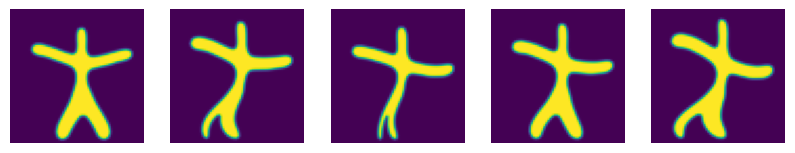

In [3]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [4]:
input_dim = (1, 28, 28)
f = 14 #subsampling factor
latent_dim = 3* (28 // f) * (28 // f)
print('Latent dim:', latent_dim)

device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-08-01_16-38-44/final_model').to(device)
vae.eval()


Latent dim: 12


VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
  

In [5]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


######## UNET #######
# in_channels = 3
# out_channels = 3
# channels = 64
# n_res_blocks = 2
# attention_levels = [3]
# channel_multipliers = (1, 2, 2, 4)
# n_heads = 2

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

h, w = 28//f, 28//f


z = torch.randn(1, 3, h, w)
print("Shape of input U-NET: ", z.shape)
empty_prompt_embed = None
print("Shape of output: ", unet(z, torch.tensor([10]), empty_prompt_embed).shape)
print("Number of trainable params: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.0012


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
# print("Number of trainable params (should not change): ", sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))
# model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_12/checkpoints/epoch=49-step=1600.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

# BATCH_SIZE = 256

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
# val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

# print()
# print('Should be equal to linear end...')
# print(model.ldm.beta[-1].item())

Shape of input U-NET:  torch.Size([1, 3, 2, 2])
Shape of output:  torch.Size([1, 3, 2, 2])
Number of trainable params:  2223043


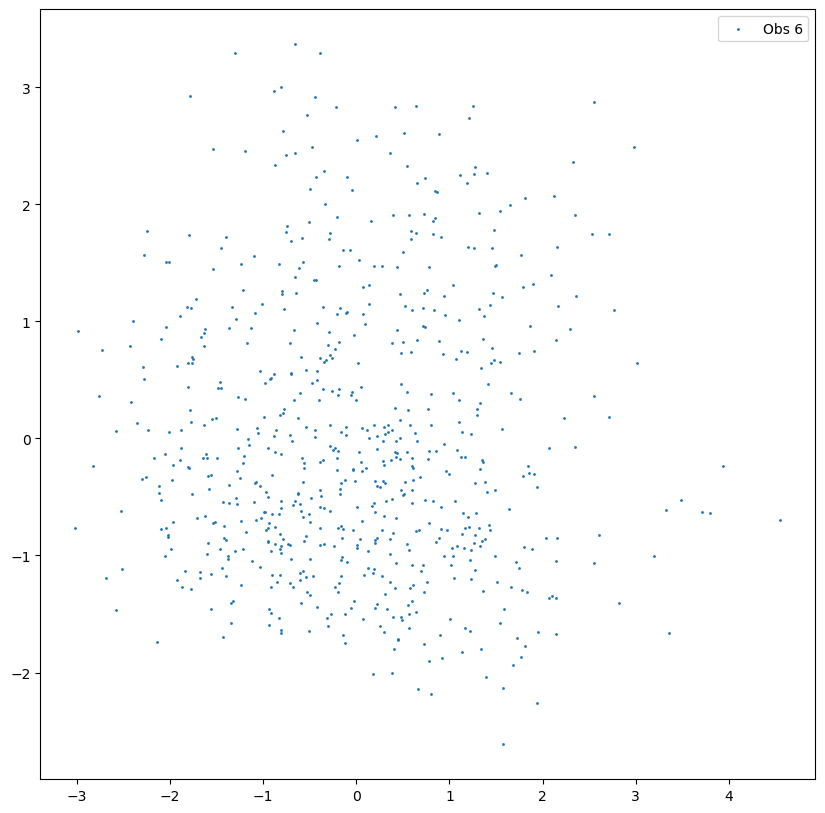

In [6]:
from sklearn.decomposition import PCA


train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding.detach()
pca = PCA(n_components=2)
pca.fit(train_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], label=f'Obs {6}', s= 1)

plt.legend()
plt.show()

In [9]:
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 5*1e-6
BATCH_SIZE = 64
MAX_EPOCHS = 100

vae = vae.to('cuda')
latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
model = LitLDM(ldm = latent_diffusion, vae = vae, lr = lr).to('cuda')



train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, train_loader, val_loader)

#model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type              | Params
-------------------------------------------
0 | ldm  | MyLatentDiffusion | 2.2 M 
1 | vae  | VAE               | 1.1 M 
-------------------------------------------
2.2 M     Trainable params
1.1 M     Non-trainable params
3.3 M     Total params
13.197    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [10]:
vae = vae.to('cuda')
model = model.to('cuda')
trainer = L.Trainer()
trainer.validate(model, val_loader)
trainer.validate(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /users/eleves-a/2020/meilame.tayebjee/variational_inference_for_longitudinal_data/experiments/starmen/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     6.463832855224609     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     5.986930847167969     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 5.986930847167969}]

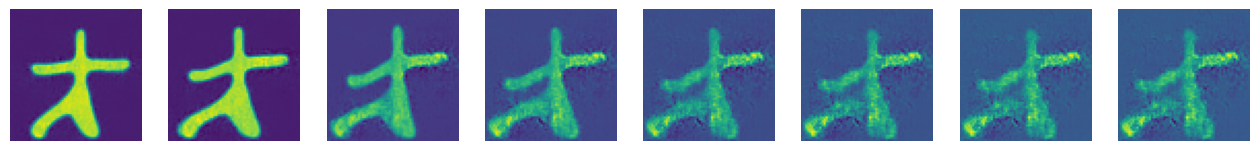

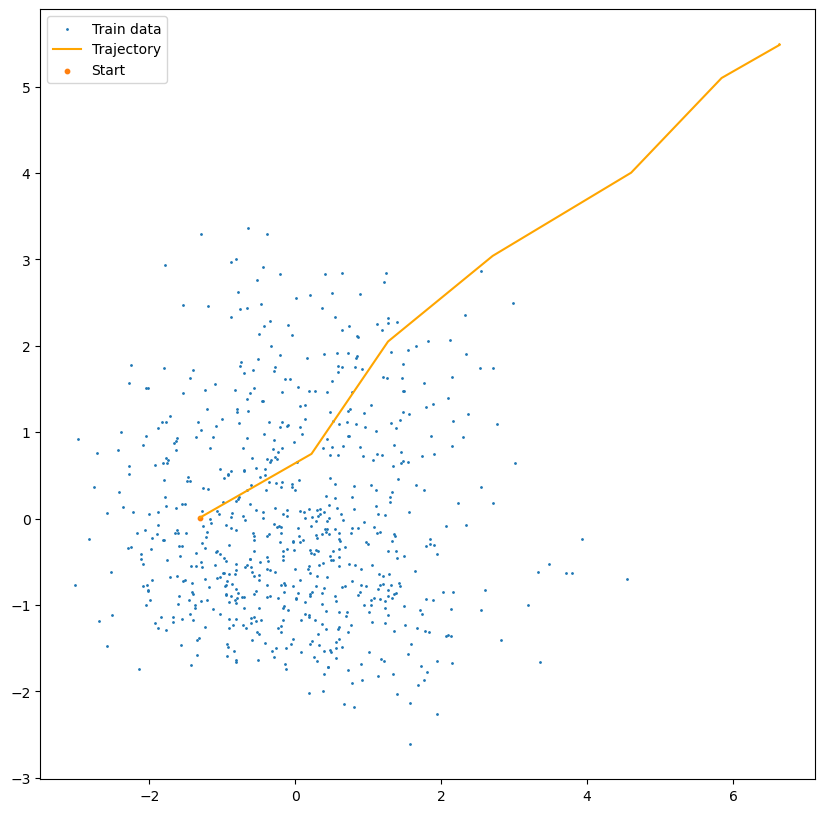

In [16]:
#Generation
c,h,w =1, 64, 64


vae = vae.to('cpu')
model = model.to('cpu')
sampler = DDIMSampler(model.ldm, n_steps = 6, ddim_eta  = 1)
#sampler = DDPMSampler(model.ldm)

start = torch.randn(1, model.c, model.h, model.w).to('cpu')
#z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None,selected_time_steps = [i* 999 // 7 for i in range(8)])
z, all_z, all_pred_z0 = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
z = z.reshape(-1, latent_dim).float()
x = vae.decoder(z).reconstruction.reshape(-1, c, h, w)


all_z = all_z.squeeze(1).reshape(-1, latent_dim)
all_pred_z0 = all_pred_z0.squeeze(1).reshape(-1, latent_dim)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, c, h, w)
all_pred_x0 = vae.decoder(all_pred_z0).reconstruction.reshape(-1, c, h, w)




plt.figure(figsize=(16, 24))
for i in range(8):
    plt.subplot(1, 8, i+1)
    #plt.imshow(all_x[12*i].detach().permute(1, 2, 0))
    plt.imshow(all_x[i].detach().permute(1, 2, 0))
    plt.axis('off')
plt.show()

# plt.figure(figsize=(16, 24))
# for i in range(8):
#     plt.subplot(1, 8, i+1)
#     plt.imshow(all_pred_x0[i].detach().permute(1, 2, 0))
#     plt.axis('off')
# plt.show()


train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
#train_embeddings = torch.load('preembedding-last.pt')
start = start.reshape(-1, latent_dim).float()
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.detach().numpy())
start_pca = pca.transform(start.detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)
#plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 10, label='Generated data')
plt.plot(all_z_pca[:, 0], all_z_pca[:, 1], label='Trajectory', c = 'orange')
plt.scatter(start_pca[:, 0], start_pca[:, 1], s=10, label = "Start")
plt.legend()
plt.show()


# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(x[i].detach().permute(1, 2, 0))
#     plt.axis('off')
# plt.show()


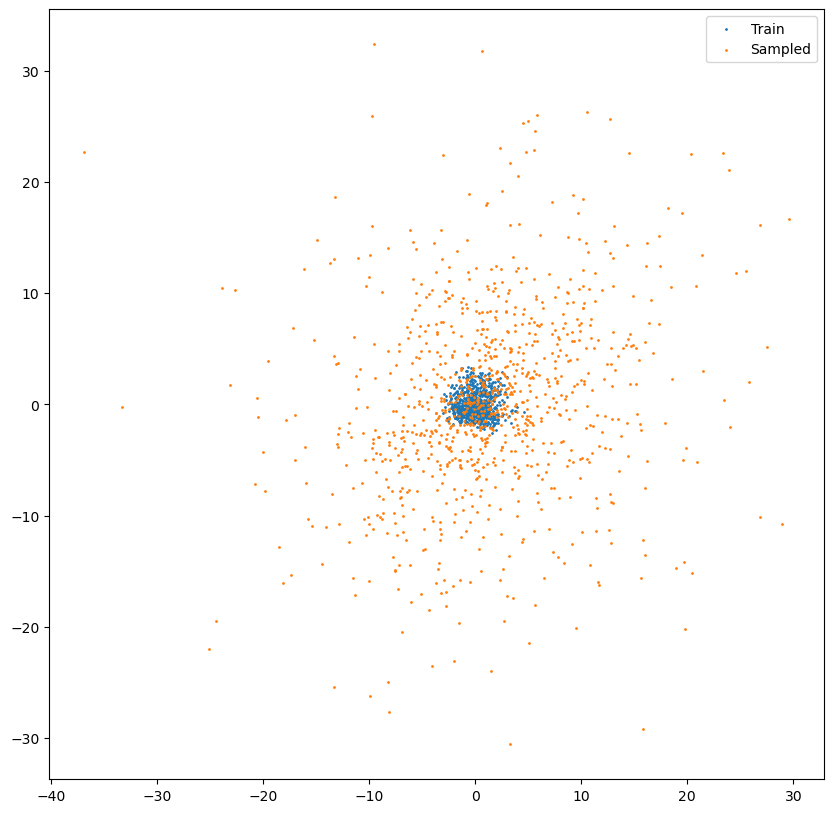

In [17]:
NUM_POINTS = 1000
train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
start = torch.randn(NUM_POINTS, model.c, model.h, model.w).to('cpu')
z, all_z, all_pred_z0 = sampler.sample(shape=(NUM_POINTS, model.c, model.h, model.w), x_last = start, cond=None, temperature=0)

z = z.reshape(-1, latent_dim).float()
start = start.reshape(-1, latent_dim).float()

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())
z_pca = pca.transform(z.detach().numpy())
start_pca = pca.transform(start.detach().numpy())


plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], s=1, label = "Train")
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=1, label = "Sampled")

#plt.scatter(start_pca[:, 0], start_pca[:, 1], s=10, label = "Start")
plt.legend()
plt.show()


In [18]:
x = next(iter(val_loader))[3]
vae = vae.to('cpu')
model = model.to('cpu')
z_orig = vae.encoder(x).embedding.float()
x_rec = vae.decoder(z_orig).reconstruction.reshape(3, 64, 64).detach()
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Reconstructed')
plt.imshow(x_rec.permute(1, 2, 0))
plt.axis('off')
plt.show()

all_noisy_z = [z_orig]
plt.figure(figsize=(16, 24))
ts = [125*i for i in range(1, 8)]
for i in range(7):
    noise = torch.randn_like(z_orig)
    prev_z = all_noisy_z[-1]

    #noisy_z = model.ldm.add_noise(prev_z, noise, torch.tensor([125])).float()
    #noisy_z = model.ldm.add_noise(z_orig, noise, torch.tensor([ts[i]])).float()

    if i> 0:
        noisy_z = model.ldm.sequential_diffusion(prev_z, np.array(ts[i-1]), np.array(ts[i]), noise).float()
    else:
        noisy_z = model.ldm.sequential_diffusion(prev_z, np.array(0), np.array(ts[i]), noise).float()

    all_noisy_z.append(noisy_z)

    noisy_x = vae.decoder(noisy_z.reshape(-1, latent_dim)).reconstruction.reshape(3, 64, 64).detach()

    plt.subplot(1, 7, i+1)
    plt.title('Noise level = ' + str(ts[i]))
    plt.imshow(noisy_x.permute(1, 2, 0))
    plt.axis('off')
plt.show()

sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
sampler.time_steps = ts
#sampler = DDPMSampler(model.ldm)


start = noisy_z.reshape(-1, model.c, model.h, model.w)
#z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None, selected_time_steps=[i* 999 // 7 +1 for i in range(8)], temperature = 0)
z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None, temperature = 0.2)
z = z.reshape(-1, latent_dim).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, latent_dim)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64).detach()
plt.figure(figsize=(16, 24))
for i in range(7):
    plt.subplot(1, 7, i+1)
    #plt.title('Pred level ' + str(ts[-i-2]) + '|' + str(ts[-i-1]))
    plt.imshow(all_x[i].permute(1, 2, 0))
    plt.axis('off')
    z_pred = all_z[i]
    z_target = all_noisy_z[-i-2].reshape(-1, latent_dim)
    print(nn.MSELoss(reduction = 'sum')(z_pred, z_target))
    print('Baseline2: ', nn.MSELoss(reduction = 'sum')(z_orig, z_target))
    print('Baseline3: ', nn.MSELoss(reduction = 'sum')(z_pred, z_orig))
plt.show()

RuntimeError: shape '[3, 64, 64]' is invalid for input of size 4096

In [ ]:
torch.random.manual_seed(0)
x0 = next(iter(val_loader))[100]
z0 = vae.encoder(x0).embedding.float()

In [ ]:
torch.random.manual_seed(0)
index = 1
sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
print(sampler.time_steps)

noise = torch.randn_like(z0)
z1 = sampler.q_sample(x0 = z0, index=index, noise = noise)
print(((z1 - z0)**2).sum())


z1_check = model.ldm.sequential_diffusion(z0, t1 = 0, t2 = 143, noise = noise)

z1_check_ldm = model.ldm.add_noise(z0, noise = noise, t = torch.tensor([143]))

print(((z1 - z1_check)**2).sum())
print(((z1 - z1_check_ldm)**2).sum())


print('coeff x ddim ', sampler.ddim_alpha_sqrt[index])
print('coeff noise ddim ', sampler.ddim_sqrt_one_minus_alpha[index] )

[  1 143 285 427 569 711 853 995]
tensor(2.4732)
coeff x  tensor([[0.9152]], dtype=torch.float64)
coeff noise  tensor([[0.4030]], dtype=torch.float64)
coeff x ldm  tensor([[0.9152]], dtype=torch.float64)
coeff noise ldm  tensor([[0.4030]])
tensor(2.8731e-14, dtype=torch.float64)
tensor(2.7609e-14, dtype=torch.float64)
coeff x ddim  tensor(0.9152)
coeff noise ddim  tensor(0.4030)


In [ ]:
torch.random.manual_seed(0)
noise = torch.randn_like(z1)
index = 2
z2_ddim = sampler.q_sample(x0 = z1, index=index, noise = noise)
z2_check = model.ldm.sequential_diffusion(z1, t1 = 143, t2 = 285, noise = noise)
z2_ldm = model.ldm.add_noise(z1, noise = noise, t = torch.tensor([285]))

print(((z2_ddim - z2_check)**2).sum())
print(((z2_ddim - z2_ldm)**2).sum())

print('coeff x ddim ', sampler.ddim_alpha_sqrt[index])
print('coeff noise ddim ', sampler.ddim_sqrt_one_minus_alpha[index] )


coeff x  tensor([[0.8581]], dtype=torch.float64)
coeff noise  tensor([[0.5135]], dtype=torch.float64)
coeff x ldm  tensor([[0.7847]], dtype=torch.float64)
coeff noise ldm  tensor([[0.6199]])
tensor(0.1737, dtype=torch.float64)
tensor(4.3845e-15, dtype=torch.float64)
coeff x ddim  tensor(0.7847)
coeff noise ddim  tensor(0.6199)


In [19]:
from torchmetrics.image.fid import FrechetInceptionDistance
NUM_POINTS = 1000

model = model.to('cpu')
vae = vae.to('cpu')
sampler = DDIMSampler(model.ldm, n_steps = 6, ddim_eta = 1)
start = torch.randn(NUM_POINTS, model.c, model.h, model.w)
fake_images, _, _ = sampler.sample(shape=(NUM_POINTS, model.c, model.h, model.w), x_last = start, cond=None, temperature = 1)

rand_indxes = torch.randint(0, 8000, (NUM_POINTS,))
real_images = vae.encoder(train_data[rand_indxes]).embedding.reshape(-1, model.c, model.h, model.w)

fid = FrechetInceptionDistance(normalize=True)
fid.update(real_images, real=True)
fid.update(fake_images, real=False)

print(fid.compute())


IndexError: index 2392 is out of bounds for dimension 0 with size 700